<a href="https://colab.research.google.com/github/techksraj/pyspark-playground/blob/main/Apache_Iceberg_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Apache Iceberg

###What is Apache Iceberg?
Apache Iceberg is an open-source table format for massive analytic datasets originally developed by Netflix. Iceberg addresses the limitations of traditional data lake storage methods by providing a high-performance format with built-in capabilities for schema evolution, partition evolution, and time travel operations.

Unlike traditional Hive tables or simple file collections, Iceberg maintains a versioned “snapshot” approach to table state, tracking all changes to table data with atomic operations. This design allows for consistency guarantees that were previously only available in traditional database systems.

###Key Features


*   Schema Evolution
*   Time Travel and Snapshot Isolation
*   Partition Evolution
*   Performance Optimizations



#Delta Lake vs Iceberg vs Hudi


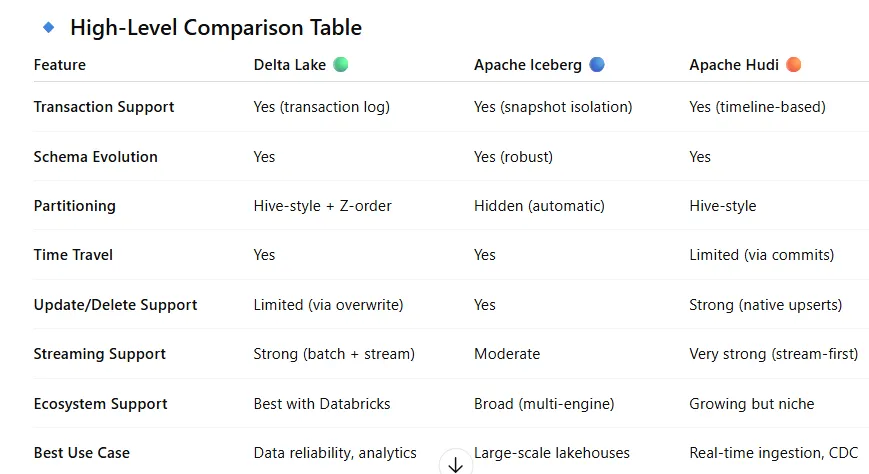


source: medium.com

In [2]:
!pip uninstall -y pyspark
!pip install pyspark==3.5.1


Found existing installation: pyspark 4.0.1
Uninstalling pyspark-4.0.1:
  Successfully uninstalled pyspark-4.0.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 15.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=948175b0e9af595aea03356ce7e73209e78caad344955eefcd8f2eb250fa8898
  Stored in directory: /root/.cache/pip/wheels/b1/91/5f/283b53010a8016a4ff1c4a1edd99bbe73afacb099645b5471b
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.9
    Uninstalling py4j-0.10.9.9:
      Successfully uninstalled py4j-0.10.9.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 1.0.1 requires pyspark[connect]~=4.0.0, 

In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("IcebergGoogleColabDevelopment")
    .config(
        "spark.jars.packages",
        "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.1"
    )
    .config(
        "spark.sql.extensions",
        "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions"
    )
    .config(
        "spark.sql.catalog.local",
        "org.apache.iceberg.spark.SparkCatalog"
    )
    .config("spark.sql.catalog.local.type", "hadoop")
    .config(
        "spark.sql.catalog.local.warehouse",
        "spark-warehouse/iceberg"
    )
    .getOrCreate()
)

print("Spark:", spark.version)


Spark: 3.5.1


In [2]:
df = spark.read.csv("sample_data/california_housing_test.csv", header=True, inferSchema=True)
df.show(truncate=False)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|-122.05  |37.37   |27.0              |3885.0     |661.0         |1537.0    |606.0     |6.6085       |344700.0          |
|-118.3   |34.26   |43.0              |1510.0     |310.0         |809.0     |277.0     |3.599        |176500.0          |
|-117.81  |33.78   |27.0              |3589.0     |507.0         |1484.0    |495.0     |5.7934       |270500.0          |
|-118.36  |33.82   |28.0              |67.0       |15.0          |49.0      |11.0      |6.1359       |330000.0          |
|-119.67  |36.33   |19.0              |1241.0     |244.0         |850.0     |237.0     |2.9375       |81700.0           |
|-119.56  |36.51   |37.0

In [3]:
df.write.format("iceberg") \
  .mode("overwrite") \
  .saveAsTable("local.housing.california_housing")

california_housing = spark.sql(
    "SELECT * FROM local.housing.california_housing"
)

california_housing.show(truncate=False)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|-122.05  |37.37   |27.0              |3885.0     |661.0         |1537.0    |606.0     |6.6085       |344700.0          |
|-118.3   |34.26   |43.0              |1510.0     |310.0         |809.0     |277.0     |3.599        |176500.0          |
|-117.81  |33.78   |27.0              |3589.0     |507.0         |1484.0    |495.0     |5.7934       |270500.0          |
|-118.36  |33.82   |28.0              |67.0       |15.0          |49.0      |11.0      |6.1359       |330000.0          |
|-119.67  |36.33   |19.0              |1241.0     |244.0         |850.0     |237.0     |2.9375       |81700.0           |
|-119.56  |36.51   |37.0

In [4]:
row_count = california_housing.count()
print(f"Number of rows: {row_count}")

Number of rows: 3000


In [5]:
california_housing.writeTo("local.housing.california_housing").append()
california_housing.show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -122.05|   37.37|              27.0|     3885.0|         661.0|    1537.0|     606.0|       6.6085|          344700.0|
|   -118.3|   34.26|              43.0|     1510.0|         310.0|     809.0|     277.0|        3.599|          176500.0|
|  -117.81|   33.78|              27.0|     3589.0|         507.0|    1484.0|     495.0|       5.7934|          270500.0|
|  -118.36|   33.82|              28.0|       67.0|          15.0|      49.0|      11.0|       6.1359|          330000.0|
|  -119.67|   36.33|              19.0|     1241.0|         244.0|     850.0|     237.0|       2.9375|           81700.0|
|  -119.56|   36.51|    

In [6]:
row_count = california_housing.count()
print(f"Number of rows: {row_count}")

Number of rows: 6000


###Exploring Time Travel
One of Iceberg most powerful features is the ability to view table history and travel back in time:

In [7]:
spark.sql("SELECT * FROM local.housing.california_housing.history").show()


+--------------------+-------------------+-------------------+-------------------+
|     made_current_at|        snapshot_id|          parent_id|is_current_ancestor|
+--------------------+-------------------+-------------------+-------------------+
|2026-01-05 09:46:...|4539943311026893461|               NULL|               true|
|2026-01-05 09:46:...| 963132989753187815|4539943311026893461|               true|
+--------------------+-------------------+-------------------+-------------------+



###Rolling Back to a Previous Version
We can identify the initial snapshot ID and roll back to it:

In [8]:
snapshot_id = spark.sql("SELECT snapshot_id FROM local.housing.california_housing.history where parent_id is null").collect()[0][0]
snapshot_id

4539943311026893461

In [9]:
spark.sql(f"CALL local.system.rollback_to_snapshot('local.housing.california_housing', {snapshot_id})")

DataFrame[previous_snapshot_id: bigint, current_snapshot_id: bigint]

In [11]:
california_housing = spark.sql(
    "SELECT * FROM local.housing.california_housing"
)

In [12]:
row_count = df.count()
print(f"Number of rows: {row_count}")

Number of rows: 3000
